In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
names = open("names.txt", "r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
### Build the vocab ###

#find all characters in our dataset
vocab = sorted(list(set(''.join(names))))
vocab.insert(0, ".")

#create vocab mappings
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for idx, char in enumerate(vocab)}

In [4]:
context_len = 3
X, Y = [], []

counter_for_show = 0
names_for_show = 3
for name in names:
    #initalise context with "." characters (index 0)
    context = [0] * context_len
    
    if counter_for_show < names_for_show:
        print(name)
    
    for char in name + ".": # add end character to the name
        y = char_to_idx[char]
        X.append(context)
        Y.append(y)
        
        if counter_for_show < names_for_show:
            print(f'{"".join(idx_to_char[idx] for idx in context)} ---> {idx_to_char[y]} | {context} ---> {y}')

        #shift the context (like a rolling window)
        context = context[1:] + [y]
    
    if counter_for_show < names_for_show:
        print(end='\n')
    counter_for_show += 1

#store as tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e | [0, 0, 0] ---> 5
..e ---> m | [0, 0, 5] ---> 13
.em ---> m | [0, 5, 13] ---> 13
emm ---> a | [5, 13, 13] ---> 1
mma ---> . | [13, 13, 1] ---> 0

olivia
... ---> o | [0, 0, 0] ---> 15
..o ---> l | [0, 0, 15] ---> 12
.ol ---> i | [0, 15, 12] ---> 9
oli ---> v | [15, 12, 9] ---> 22
liv ---> i | [12, 9, 22] ---> 9
ivi ---> a | [9, 22, 9] ---> 1
via ---> . | [22, 9, 1] ---> 0

ava
... ---> a | [0, 0, 0] ---> 1
..a ---> v | [0, 0, 1] ---> 22
.av ---> a | [0, 1, 22] ---> 1
ava ---> . | [1, 22, 1] ---> 0



In [5]:
print(f"{X.shape} with dtype: {X.dtype}")
print(f"{Y.shape} with dtype: {Y.dtype}")

torch.Size([228146, 3]) with dtype: torch.int64
torch.Size([228146]) with dtype: torch.int64


Our Dataset consists of 228146 examples of context length 3. Each example represents the index into our vocab. Now lets split this into training, validation and test sets.

In [6]:
def create_dataset(names, context_len=3):
    """Function to create a dataset out of a list of names given to it

    Args:
        names (list)
        context_len (int, optional):Defaults to 3.

    Returns:
        tuple: X, Y
    """

    X, Y = [], []
    for name in names:
        #initalise context with "." characters (index 0)
        context = [0] * context_len
        
        for char in name + ".": # add end character to the name
            y = char_to_idx[char]
            X.append(context)
            Y.append(y)
        
            #shift the context (like a rolling window)
            context = context[1:] + [y]

    #store as tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [7]:
## Split simply by indexing
random.shuffle(names)
train_split = int(0.8*len(names)) #80% for train
val_split = int(0.9*len(names)) #10% for each of val and test

X_train, Y_train = create_dataset(names[:train_split])
X_val, Y_val = create_dataset(names[train_split:val_split])
X_test, Y_test = create_dataset(names[val_split:])

In [8]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182751, 3]) torch.Size([182751])
torch.Size([22687, 3]) torch.Size([22687])
torch.Size([22708, 3]) torch.Size([22708])


### Network

![](nn_arch.png)


**Input**

The network takes as input the indexes of the vocab corresponding to the context. In this case the context is of length three.


**Embedding**

Next is the embedding transformation. We take the indexes and embed them into a space (of dimension we can choose, say, 2dim). So each character in our vocab goes from an integer to a vector of len(emb_dim). The best way to think of this is as an embedding matrix, C, which has dimension (len(vocab), emb_dim) i.e. each row represents a character and we use the index of that character in our vocab to index into this matrix. (e.g. "." character is idx=0 in vocab, which has embeding=C[0] which is a vector of len(emb_dim)).

So for 1 example with context length 3 we start with a vector of len(context_length)=3, which represent the indicies in our vocab. Each index then get transformed (i.e. embedded) to a vector of len(emb_dim), say emb_dim=10, and then get concatinated. So 3 indicies tranform to 3 vectors of len(emd_dim) and then aligned together. (vector of len=30 if emd_dim=10 and context=3)

**Linear Layer**

Just a standard Linear Layer, with say 100 neurons (we choose), that has a tanh activation.

**Output Layer**

The output layer is a Linear Layer, with len(vocab)=27 neurons, with softmax activation. This gives us a probility distribution over the vocab. So each of the 27 outputs represents the probability that the next character given the context is that character (soOutput[0] is the probability, given the context the next character is index 0 in our vocab which is "."). Note: that in training we utalise `.cross_entropy()` which internally calculates the softmax and compute the cross entropy of our ouput with the true index (given by Y)


Notice they are the roughly the same. This suggested there is still room for imrpovement. But before that lets visualise the embedding matrix

In [17]:
### Train network ###

## dims + embedding dims ##
vocab_len=27
context_len=3
emb_dim = 2

ll_neurons = 250
mini_batch_size=64

iterations = 100_000


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((vocab_len, emb_dim))
w1 = torch.randn((context_len*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, vocab_len)) 
b2 = torch.randn((vocab_len)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   # construct batches by randomly selecting integers. use integers to index into training set
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, context_len, emb_dim) 
    h1 = torch.tanh(emb.view(-1, context_len*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, vocab_len) we want to produce p(next_char over dist given the seq) hence vocab_len
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 50_000:
        lr=0.1
    elif ((i>50_000) & (i<80_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    
    
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")

Current Loss: 26.711
Current Loss: 2.520
Current Loss: 2.400
Current Loss: 2.398
Current Loss: 2.470
Current Loss: 2.670
Current Loss: 2.269
Current Loss: 2.209
Current Loss: 2.369
Current Loss: 2.307


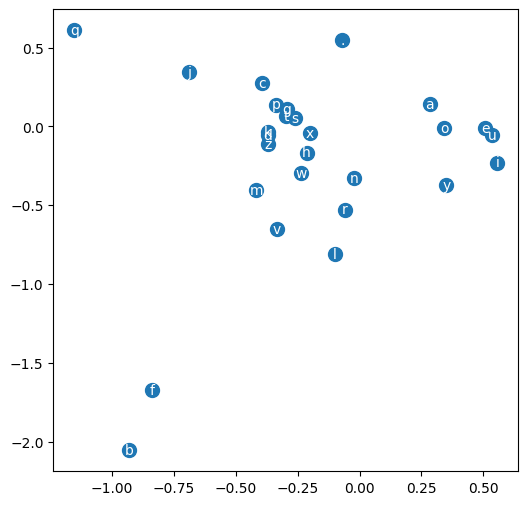

In [18]:
### Visualise the Embeddings of our characters ###

plt.figure(figsize=(6,6))
#plot the dims of the embedding matrix
plt.scatter(C[:, 0].data, C[:, 1].data, s=100)

#iterate through and on the dot place the letter
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), s=idx_to_char[i], ha="center", va="center", color="white")

Intrestingly, the vowels are clustered together! The model assigns similarlity to these, meaning theyre interchangeable in a sense!
There are the main cluster of letters in the center. 
there are q and . that are far away  aswell as b and f from the main cluster indicating that these are exceptional characters. Fasinating!!

Now lets play around with the hyper paramters to try and get a best model. Here we are doing this in a trail and error, unstructured way, but we'll learn about best practices soon. Lets just play for now!

Hyperparameters:
* Number of neurons in the linear layer
* batch_size
* number of dimensions in our embeddings
* learning rate
* context length

In [ ]:
### Train network ###

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 100_000


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 50_000:
        lr=0.1
    elif ((i>50_000) & (i<80_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")

Current Loss: 32.432
Current Loss: 2.776
Current Loss: 2.294
Current Loss: 2.645
Current Loss: 2.226
Current Loss: 2.204
Current Loss: 2.098
Current Loss: 2.360
Current Loss: 2.197
Current Loss: 2.059


In [ ]:
## Run Forward pss on training set to get training loss

emb = C[X_train]
h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #<-- context_len=3
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_train)
print(f"training loss: {loss.item():.3f}")

training loss: 2.141


In [ ]:
## Run forward pass on validation data to get validation loss
emb = C[X_val]
h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1)
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_val)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.181


### Sampling from the model

The model is trained. it has adjusted its weights to best minimise the loss. Now it is time to generate new samples. Think lets pass one data point through the forward pass. Starting with context="..." until we draw a "." to represent the end of our name

In [ ]:
generated_chars = []
NUMBER_OF_NAMES = 10

for _ in range(NUMBER_OF_NAMES):
    #start with ...
    context = [0] * 3
    
    while True:
        #send it through the forward pass
        emb = C[context] #(1_example, context_len, emb_dim) = (1, 3, 10)
        h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(1, ll_neuron)
        logits = h1 @ w2 + b2 #(1, 27) <-- 27 is length of our vocab 

        #now we create the prob dist (note: this was previously done internallu in cross_entorpy - but we dont want t he loss calculation, we want the prob dist)
        prob_dist = F.softmax(logits, dim=1) #logits is a row vector, so calculate over the row (i.e. across dim 1 which the columns across the columns gives over the row)

        #now we sample from the dist (a multinomal will do that for us)
        idx = torch.multinomial(prob_dist, 1).item()
        generated_chars.append(idx_to_char[idx])

        if idx == 0:
            break

        context = context[1:] + [idx]

    print("".join(generated_chars))
    generated_chars=[]

jacklin.
sina.
alicaily.
barisemasa.
azcetain.
sathleey.
lidiah.
ect.
max.
hia.
